## Activity Recognition
#### Problem Summary, Analysis & Prediction

#### Problem Summary
15 participants wore an accelerometer mounted to their chest while performing various activities (listed below). 

1. Working at Computer
2. Standing up, Walking and Going Up/Down Stairs
3. Standing
4. Walking
5. Going Up/Down Stairs
6. Walking and Talking w/ Someone
7. Talking while Standing

The accelerometer captured acceleration measurements in all three dimensions - **X, Y and Z**. The goal is not only to be able to predict what activity is being performed, but, more importantly, to understand the intuition behind that prediction and what separates the different activites.

Some questions that will be considered are:

* How does the distribution of data across subjects and classes affect prediction accuracy?
* What are the data limitations?
* How does the sequential nature of the problem come into play?

*A note on data cleaning - There was one instance at the end of each file that had the label set as '0'. Since this was consistent across all data files, and these instances were all after the sequences of data with the activity label '7', I assigned these instances the label of '7', since '0' was not a valid activity given in the problem description*

In [1]:
from src.format_data import *
from src.plotting import *
%matplotlib inline

data_dir = 'data/'

files = [data_dir + f'{i}.csv' for i in range(1, 16)]
subject_names = [str(i) for i in range(1, 16)]

# importing data - check src/format_data.py for aggregate_subjects function
df = aggregate_subjects(files, subject_names)

#### Data Summary & Aggregation

The two plots below shows the distribution of data across subjects and activities in the data set. Viewing the data set in this holistic manner gives us some insight that might otherwise go unnoticed. 

Since the the data set consists of 15 subjects, it is important to ensure that any one subject doesn't account for a disproportionally large percentage of the data set. If this were the case (e.g. if subject 15 accounted for 0.5, or 50% of the data set), the data that we would have would be inherently biased towards that particular person. Luckily, this isn't the case. Although subject 13 accouns for the smallest percentage of our data (roughly 3.5%), the top percentages are only around 8.5%, so this discrepancy isn't a grave concern.

This is not the case for the distribution of activites. As one can see, the first three activites only account for about 2.5% of the data each. Compounding that, *Talking while Standing* and *Working at Computer* dominate the distribution, each coming in at over 30%. This will have to be kept in mind during the modeling phase. When we reach the modeling and evaluation phase, I will explain why this can have an affect on prediction accuracy.

##### A Note on Data Limitations

It is important to note that although the absolute quantity of observations this data set contains is quite high (roughly 2 million), there were only *15* people from whom measurements were taken.

In the grand scheme of things, this is relatively small sample. Since we are working with accelerometer data, we should keep in mind that not only can a peron's physical body size play a role in how their body move, but *personality* can also have a role (i.e. some people are very 'active' speakers - hand motions could lead to minor movements in someone's upper body, which would be captured by the accelerometer).

Since we only have 15 particpants, there is no way to tell whether this variation has been captured by who ever designed this experiment.

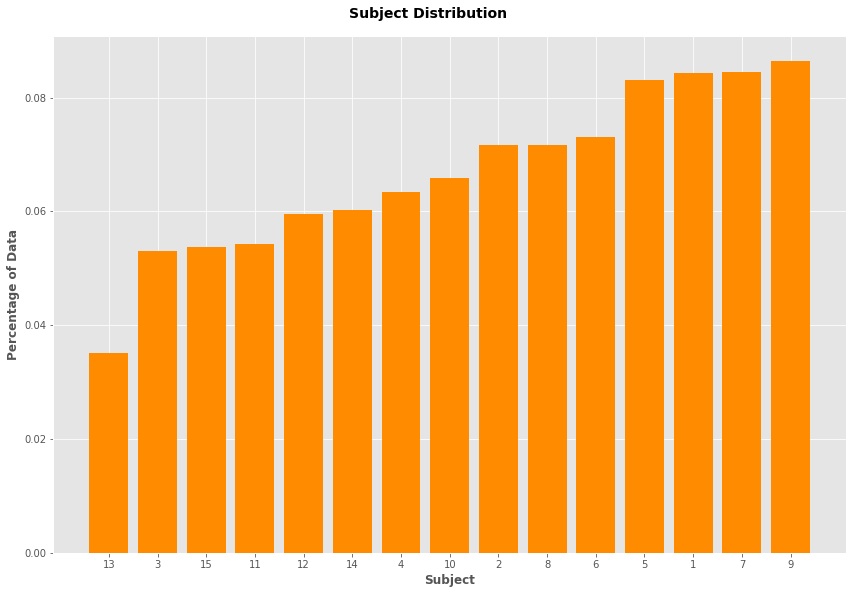

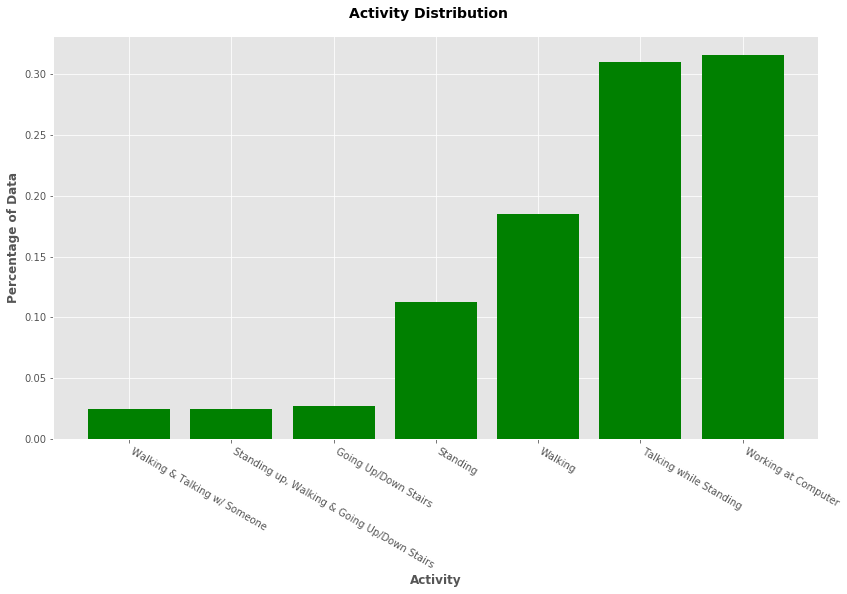

In [2]:
# check src/plotting.py for bar_plot function

# distribution of subjects
proportion = df.groupby('subject').count()['seq'] / df.shape[0]
proportion.sort_values(inplace=True)

bar_plot(proportion.index, proportion, 'darkorange', 'Subject', 'Percentage of Data','Subject Distribution')

# distribution of activities
proportion = df.groupby('label').count()['seq'] / df.shape[0]
proportion.sort_values(inplace=True)

bar_plot(proportion.index, proportion, 'green', 'Activity', 'Percentage of Data','Activity Distribution', True)

In [3]:
df.pivot_table(index=['label'], values=['x_acc','y_acc','z_acc'], aggfunc=[np.mean, np.var])

mean               \
                                                   x_acc        y_acc   
label                                                                   
Going Up/Down Stairs                         2000.554449  2385.493844   
Standing                                     1996.272755  2378.303095   
Standing up, Walking & Going Up/Down Stairs  1969.489431  2371.051965   
Talking while Standing                       1998.340516  2389.217249   
Walking                                      1976.819111  2386.292905   
Walking & Talking w/ Someone                 2027.107076  2374.075277   
Working at Computer                          1977.689653  2376.558532   

                                                                   var  \
                                                   z_acc         x_acc   
label                                                                    
Going Up/Down Stairs                         1997.001573  12373.685338   
Standing                                     1965.729391  14772.501974   
Standing up, Walking & Going Up/Down Stairs  1940.448703  12218.512191   
Talking while Standing                       1973.384663  11223.234820   
Walking                                      1978.708646  15390.949685   
Walking & Talking w/ Someone                 1952.189366  14774.471337   
Working at Computer                          1966.415593  10318.525944   

                                                                         
                                                    y_acc         z_acc  
label                                                                    
Going Up/Down Stairs                         11637.301290   8332.503425  
Standing                                      7985.504490   4965.383460  
Standing up, Walking & Going Up/Down Stairs   7728.580544  11728.306567  
Talking while Standing                        9168.814275   4078.024975  
Walking                                      13205.771335   8276.008950  
Walking & Talking w/ Someone                  7655.687440   5795.001047  
Working at Computer                           9965.471870  15310.173892

####  Summary Statistics & Data Standardization

Looking at the table of summary statistics above, a question that will pop up (if it hasn't already) is, "What do these numbers mean?"

According to [this website](https://learn.sparkfun.com/tutorials/accelerometer-basics/all), "[Accelerometers] measure in meters per second squared $\left( \frac{meters}{second} \right)^2$, or in G-forces (g, where 1 g = 9.8 $\left( \frac{meters}{second} \right)^2$)" (at least on this planet, but we don't need to get into that...)

In addition to these units not being overly intuitive for most people, the actual values aren't of great concern. By standardizing each of the three dimensions the accelerometer measures to have mean 0 and variance 1, the units will become "standard deviations from the (overall) mean"



In [4]:
# formatting data - check src/format_data.py for aggregate_subjects function
dtype_dict = {'seq':object,
              'x_acc':float,
              'y_acc':float,
              'z_acc':float,
              'label':object,
              'subject':object}

scaled_df = standardize_df(df, ['x_acc','y_acc','z_acc'], ['seq','label','subject'], dtype_dict)

After the data has been standardized (which, again, means that **x_acc**, **y_acc** and **z_acc** have a mean equal to 0 and standard deviation equal to 1 *as a whole*) the same table as above can be interpretted more intuitively.

For example, you'll notice that the mean for "Going Up/Down Stairs" in the Z dimension is the highest out of any of the activities. This means that, although the *overall* mean for the Z dimension is 0, a relatively high value (close to 0.3) would suggest that the activity being performed is "Going Up/Down Stairs."

In [5]:
scaled_df.pivot_table(index=['label'], values=['x_acc','y_acc','z_acc'], aggfunc=[np.mean, np.std])

mean                      \
                                                x_acc     y_acc     z_acc   
label                                                                       
Going Up/Down Stairs                         0.115863  0.029617  0.279544   
Standing                                     0.077413 -0.042065 -0.051522   
Standing up, Walking & Going Up/Down Stairs -0.163103 -0.114349 -0.319159   
Talking while Standing                       0.095982  0.066734  0.029521   
Walking                                     -0.097282  0.037582  0.085884   
Walking & Talking w/ Someone                 0.354308 -0.084210 -0.194865   
Working at Computer                         -0.089464 -0.059456 -0.044258   

                                                  std                      
                                                x_acc     y_acc     z_acc  
label                                                                      
Going Up/Down Stairs                         0.998916  1.075375  0.966373  
Standing                                     1.091457  0.890810  0.745991  
Standing up, Walking & Going Up/Down Stairs  0.992633  0.876362  1.146502  
Talking while Standing                       0.951346  0.954532  0.676055  
Walking                                      1.114069  1.145554  0.963092  
Walking & Talking w/ Someone                 1.091529  0.872220  0.805905  
Working at Computer                          0.912196  0.995137  1.309927

### Outlier Detection

In a non-sequential data set, outliers are (typically) defined defined by their distance from the mean (or a some other measure of centrality). In the data set we are working with, an outlier is going to be defined as a **behavioural** outlier.

This means that we want to keep our eyes out for a participant who's behaviour while performing an activity is significantly different from the other participants. To illustrate this point, the plot below shows the x-axis accleration for each participant. Pay close attention to *Participant 12* - while most of the other participants have very little accleration in the X dimension while working at their computer, *Participant 12* seems to jump around quite frequently.

Again, if there were more vastly participants in this study who showed behaviour closer to that of the "normal" participants below, I might consider removing participant 12 altogether. However, due to the small sample size and the naturally high ambiguity of the problem (as I mentioned above, people move very differently), I will move forward with a 'mental grain of salt' with regard to participant 12.

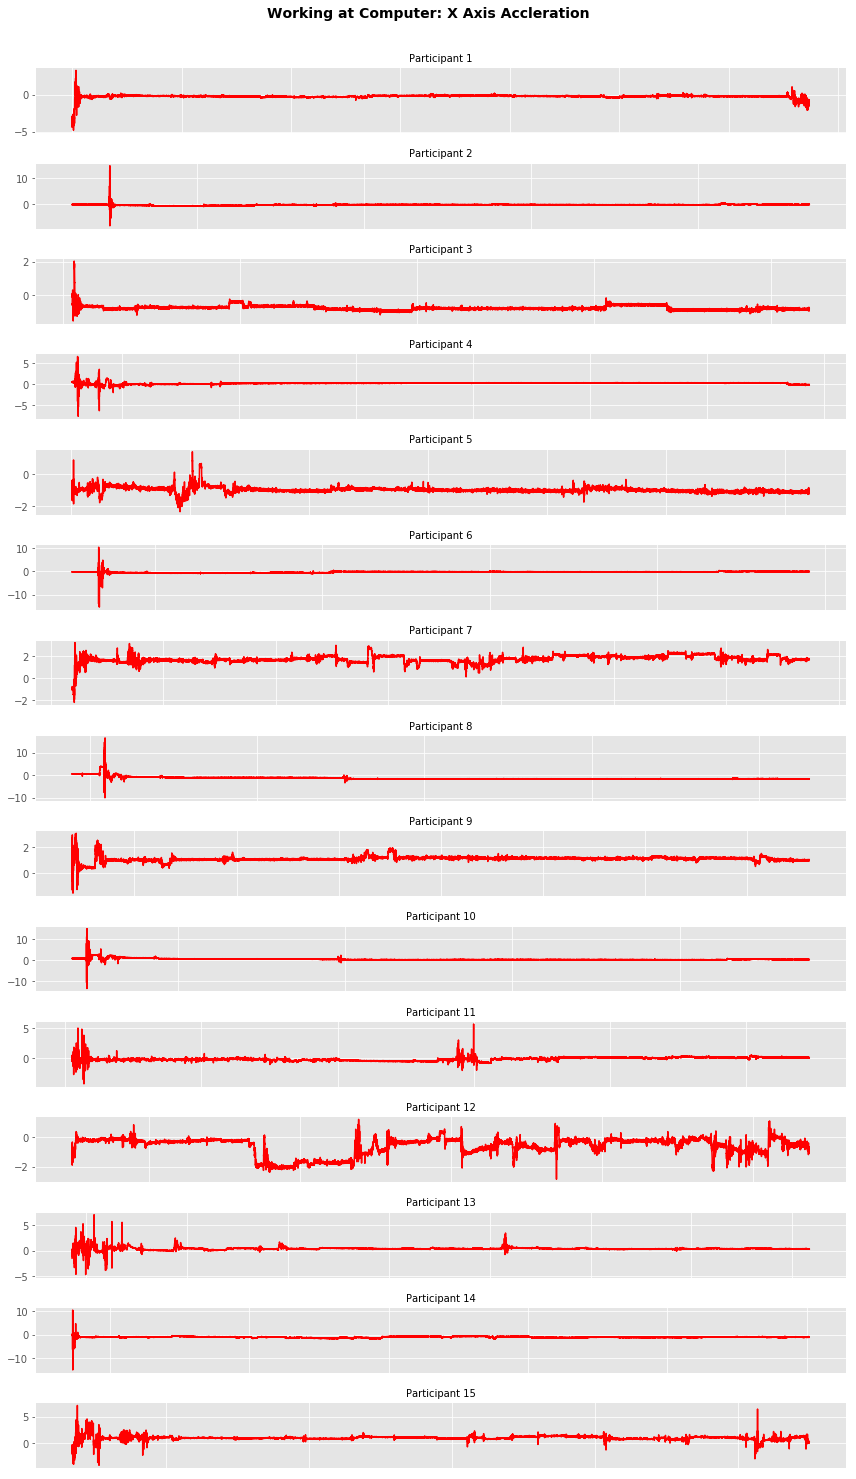

In [6]:
display_df = scaled_df[scaled_df['label'] == 'Working at Computer']
subject_comparison_plot(display_df, 'x_acc', 'red', 'Working at Computer: X Axis Accleration')

### Predictive Modeling

#### Defining a Benchmark Model

Although this data is inherently sequential, it is worth seeing if a model can predict the current activity with only the current measurement of acceleration in the X, Y and Z dimensions. We will use this as a benchmark model against which future models will be tested.

This is perfomed below using a Random Forest, which is a statistical learning method that, as the name implies, is a collection of Decision Trees.

##### Technical Explanation of Random Forests

###### Decision Trees

To fully explain what a Random Forest is, one must first start with the definition of a decision tree. A decision tree is a statistical learning algorithm that recursively splits the data set into two subsets, the (idealistic) goal of each split being to move towards having a "pure" leaf, which is defined as a region where only one class is present. In the image below, the square at the bottom right of the diagram, with the only activity being *Standing*, would be considered a "pure" leaf (i.e. all observations that have an scaled *x_acc* value greater than 0 and a scaled z_acc value greater than -0.035 are *Standing* observations)

This process of repeatedly taking a set of observations

<img src="images/decision_tree_diagram.png" style="height:750px">

###### Bagging (A Group of Decision Trees)

Now, imagine 50 decision tree's built on bootstrapped data sets (a "bootstrapped" data set is a simulated data set that is created by randomly drawing observations from our sample until we have a new data set that is the same size as the original. Every time a sample is drawn, it is replaced into the conceptual bag from which observations can be drawn). Each decision tree follows the same recursive binary splitting algorithm outline above, however since each individual tree is being trained on a slightly different data set, details of each tree will vary.

To determine what activity an unseen observation will be classified as, it is "dropped down" each of the 50 decision trees, resulting in 50 (potentially different) classifications. Once this is completed, the most frequently predicted activity is disgnated as the final prediction.

###### Random Forests

Finally, we get to Random Forests. Random Forests are almost identical to Bagging, with one minor difference; with Bagging, whenever a splitting decision has to be made, the algorithm has access to all the variables to determine the best split value possible. With a Random Forest, whenever a splitting decision has to be made, the algorithm *only has access to a subset of the variables from which it can select a split value*.

Although somewhat counter-intuitive, the intuition behind this is, by decorrelating the trees in a forest, the overall *ensemble* is able to generalize better to new, previously unseen data.

## Data Merging for Modeling

While the dataframe that has been used up to this point is useful to see how each individual performs a certain action, the goal is to build a model that generalizes to the public and can be used to predict the "average" person's behaviour.

In order to do this appropriately, I split each subject's data set into the subset's based on the activity that was being performed. After doing this, for each activity, all 15 X, Y and Z measurement were joined on the sequence in which they were performed, and averaged.

Thus, in the data set that will be used moving forward, the value in *x_acc* with *seq* 0 will be the *average* x_acc at sequence 0 across all 15 subjects.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [8]:
# importing data - check src/format_data.py for ActivitySequenceAverager Class
subject_dfs = {}
for x, filename in enumerate(files):
    subject = str(x+1)
    subject_dfs[subject] = format_csv(filename)

averager = ActivitySequenceAverager(subject_dfs.values())
averager.transform()

In [9]:
X = averager.aggregated_df[['x_acc','y_acc','z_acc']].values
y = averager.aggregated_df['label'].values

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

random_forest = RandomForestClassifier(n_estimators=300, random_state=5)

### Evaluation Metrics

Accuracy will be used as the evaluation metric, however *why* this will be used as the evaluation metric deserves a short explanation.

Although this data set has seven possible classifications, an explanation using a ficticious dichotomous decision process will drive the point home more directly.

A classic example of a process like this is medical testing. Imagine a test that tests the patient for cancer. If the patient tests positive (i.e. the test says they have cancer), they go on to the next step in the diagnosis process which is an additional $1,000 test. If the patient tests negative (the test says they don't have cancer), they are released and are able to continue with their lives.

It is clear that there are two ways the testing process can be wrong in this situation:

1. The test says they **do** have cancer when they in fact do not. This is called a False Positive. (FP for short)
2. The test says they **do not** have cancer when they in fact do. This is called a False Negative. (FN for short)

When deciding what evaluation metric to optimize for, one must take into account the costs of being wrong. In the above scenario, the cost of a FP is \\$1,000 and the time and inconvenience of an additional test to the patient who does not in fact have cancer. On the other hand, the cost of a FN is telling the patient they are okay when in reality they should start treatment immediately. The latter is clearly the worse of the two options; a patient that doesn't know they have cancer runs the risk of the cancer metastasizing, which would not only cause their medical bills to be much higher than \\$1,000 in the future, but would also increase their chance of death.

In this situation, one should be willing to sacrifice at least a couple FP's to save one FN.

Coming back to the problem at hand, there are seven different possible classifications. This means there are six ways to be *wrong* for each class. With seven classes, that comes out to **42 different ways to be wrong, and only seven ways to be right**. Since there is no clear evaluation of the costs of being wrong, I will be treating each incorrect prediction the same. That is, classifying an observation as *Walking*, when it is actually *Standing*, will be treated the same as classifying an observation as *Walking & Talking w/ Someone*, when it is actually *Working at Computer*.

In [10]:
random_forest_scores = cross_val_score(random_forest, X_train_scaled, y_train, cv=8, scoring='accuracy')

In [11]:
print('Average Accuracy | {:.2%}'.format(random_forest_scores.mean()))
print('Accuracy Std. Dev. | {:.2%}'.format(random_forest_scores.std()))

Average Accuracy | 75.84%
Accuracy Std. Dev. | 0.24%


A cross validation accuracy of 75% (and standard deviation of 0.3%) is a good benchmark on which to base further model development, especially since each observation is being treated in isolation.


### How do the Movement Patterns Differ?

The plots below show the behaviour of the different activities in sequential order, for each dimension. Although there are some similarities between the different activites, there are some movements that can be thought of quite intuitively.

For example, you will notice that *Walking* has a consistently dense variation around its mean in each dimension. This makes intuitive sense in that, while walking, there is going to be some consistent upward and downward oscillation as you roll off the ball of your foot with each step. In addition, the slight swinging of the arms while walking will rotate the shoulders slightly, which in turn will ever so slightly move the chest (where the accelerometer is located).

In [12]:
dtype_dict = {'seq':int,
              'x_acc':float,
              'y_acc':float,
              'z_acc':float,
              'label':object}

scaled_aggregated_df = standardize_df(averager.aggregated_df, ['x_acc','y_acc','z_acc'], ['seq','label'], dtype_dict)

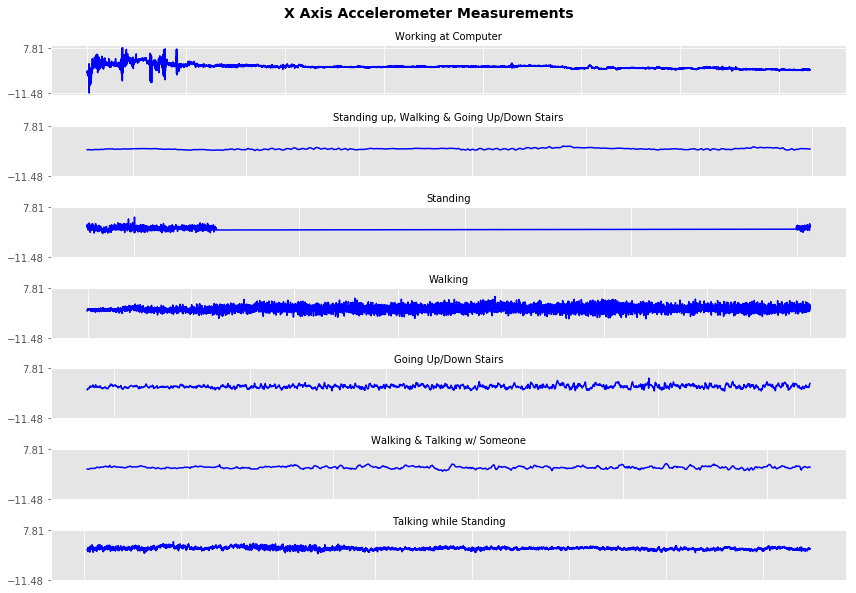

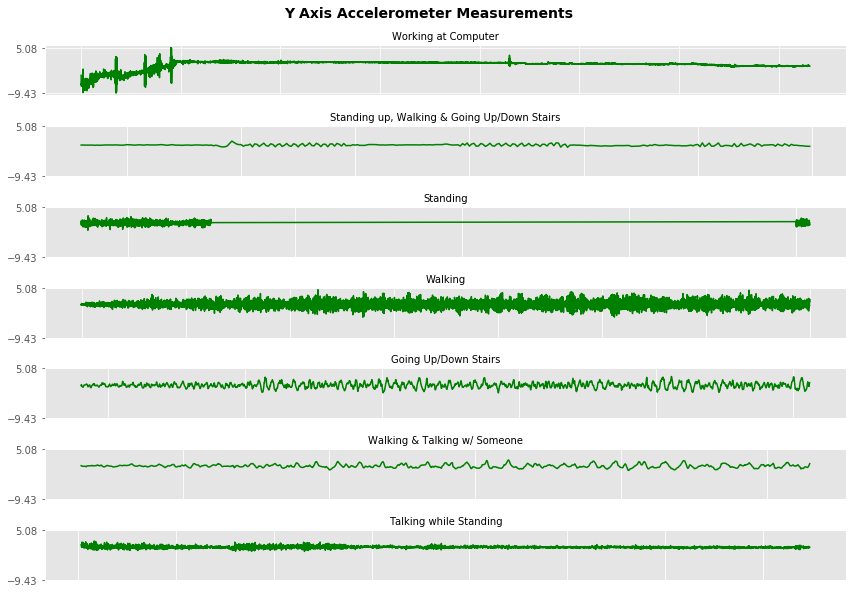

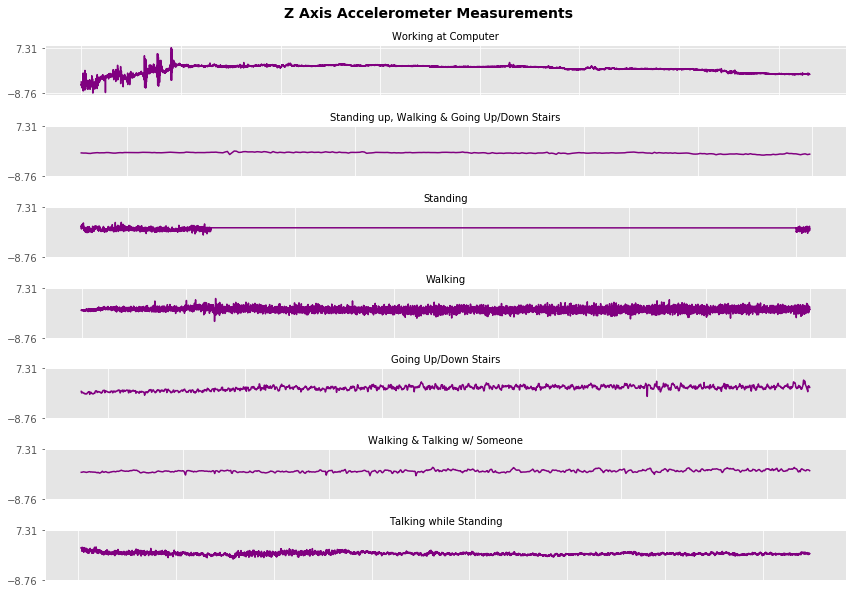

In [13]:
y_range = [np.min(scaled_aggregated_df.x_acc), np.max(scaled_aggregated_df.x_acc)]
dimension_plot(scaled_aggregated_df, 'x_acc', y_range, 'blue', 'X Axis Accelerometer Measurements')

y_range = [np.min(scaled_aggregated_df.y_acc), np.max(scaled_aggregated_df.y_acc)]
dimension_plot(scaled_aggregated_df, 'y_acc', y_range, 'green', 'Y Axis Accelerometer Measurements')

y_range = [np.min(scaled_aggregated_df.z_acc), np.max(scaled_aggregated_df.z_acc)]
dimension_plot(scaled_aggregated_df, 'z_acc', y_range, 'purple', 'Z Axis Accelerometer Measurements')

### Bringing in the Sequential Nature of the Data

Since this is a time series classification problem, we will now bring in the sequential nature of the problem.

Broadly speaking, there are is one major assumption that needs to be defined prior to moving forward:

* Should the model have access to the previous state of the subject?

Another way of phrasing this i; do we want our model to be able to use the activity the subject was performing "a moment ago" to predict the activity the subject is currently performing?

While many sequential modeling frameworks take advantage of this, I am going to assume that the only sequential aspect of the data that we would like to preserve is the accelerometers measurements in each dimension. There are a couple reasons for this:

1. The training data was presented in a very specific manner; that is, the activities were ordered as they are written at the beginning of this report (i.e. in each file, all the observations for *Working at Computer* were at the beginning of the file and immediately followed by all the observations for *Standing up, Walking and Going Up/Down Stairs*, etc.) I am assuming this purely due to the design of the experiment. In the real world, people don't follow a monotonous routine of repeating the same pattern of movements over and over again, and we would ideally like to build a model that can predict a subjects activity even if they don't perform the activities in the same order as the training data.


2. If I were to give the model access to the previous state of the subject, the modeling process would become arbitrarily easy in the sense that a highly accurate model would be to just predict the previous activity state as the current activity state. This is tangental to the problem outlined in point one - the design of the experiment had each subject perform one activity after another. A natural thought then becomes, "Just shuffle the data and this problem evaporates". Unfortunately, shuffling the data would compromise the sequential nature of the accelerometer measurements.

In order to allow our model to be able to view the sequential nature of the data set without shuffling the data, I am going to introduce new variable that allow the model to look back in time, while still preserving the independence of the observations.

In [14]:
lagged_df = create_lagged_df(averager.aggregated_df,
                             'label',
                             ['x_acc','y_acc','z_acc'])

In [15]:
# adding the labels back on
lagged_df['label'] = averager.aggregated_df['label']

An illustration of what is happening is shown below. The current implementation allows each observation to "look back" five timesteps. This is performed for all three dimensions.

<img src="images/timelag_illustration.png" style="height:250px">

As you can see in the image, this process necessarily imputes some zeros into the start of each activity dataframe. However, since there are only 7 activities and we are only creating a lag of 5 steps, dropping these observations will not be huge cost to the amount of data we have (7 x 5 = 35 observations removed). This is performed below.

In [16]:
# removing imputed zero's from data
mask = lagged_df['x_acc_T_minus_5'] != 0
mask1 = lagged_df['y_acc_T_minus_5'] != 0
mask2 = lagged_df['z_acc_T_minus_5'] != 0

trimmed_df = lagged_df[mask & mask1 & mask2].copy()

print(f'{lagged_df[~mask & ~mask1 & ~mask2].shape[0]} observations removed')

35 observations removed


In addition to adding the lag, I will create a "rolling average" over the previous 5 timesteps. This will give our data an additional attribute that will give each step the average of itself and the last 5 steps in each dimension

In [17]:
cols = list(trimmed_df.columns)
cols.remove('label')

# create rolling average
for dimension in ['x','y','z']:
    
    dimension_columns = [col for col in cols if dimension in col]
    trimmed_df[f'rolling_{dimension}_average'] = np.mean(trimmed_df[dimension_columns], axis=1)

## Lagged Data Modeling

Now that we have added a couple new attributes to our data set that not only allow it to "look back in time", but also view it's own rolling average, we will train is with the same model architecture as before to see if it outperforms our benchmark.

In [18]:
random_forest1 = RandomForestClassifier(n_estimators=300, random_state=5)

X_lag = trimmed_df.loc[:,~trimmed_df.columns.isin(['label'])].values
y_lag = trimmed_df['label'].values

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_lag, y_lag, test_size=0.25, random_state=5)

# standardizing the values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

random_forest1_scores = cross_val_score(random_forest1, X_train_scaled, y_train, cv=8, scoring='accuracy')

In [19]:
print('Average Accuracy | {:.2%}'.format(random_forest1_scores.mean()))
print('Accuracy Std. Dev. | {:.2%}'.format(random_forest1_scores.std()))

Average Accuracy | 93.85%
Accuracy Std. Dev. | 0.23%


As shown above, there is a significant increase in the prediction accuracy (with only a minor increase in the standard deviation of said accuracy) after introducing the lagged variables. Moving forward, we will used this "backward looking" data set as our final model.

In [20]:
random_forest1.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=5, verbose=0, warm_start=False)

## Conclusion

As shown below, our final model does very well on unseen data. The below is a multi-class confusion matrix displaying the final model's test set predictions against the actual test set labels. A perfect score would be a diagonal matrix, where all numbers except those along the diagonal are zero.

Even with the disproportionate class sizes, the model did a good job of classifying the observations with low representation in the data st (i.e. the activity *Standing up, Walking & Going Up/Down Stairs* had relatively low representation in the data set (roughly 170 observations in the training set and 60 in the testing set), however the model perfectly classified all these instances.

In [21]:
# scaling the test data using the training data values
X_test_scaled = scaler.transform(X_test)
y_hat = random_forest1.predict(X_test_scaled)

pd.DataFrame(data=confusion_matrix(y_test, y_hat), columns=random_forest1.classes_, index=random_forest1.classes_)

,Going Up/Down Stairs,Standing,"Standing up, Walking & Going Up/Down Stairs",Talking while Standing,Walking,Walking & Talking w/ Someone,Working at Computer
Going Up/Down Stairs,556,14,0,11,18,56,1
Standing,24,804,0,59,217,1,12
"Standing up, Walking & Going Up/Down Stairs",0,0,65,0,0,0,0
Talking while Standing,2,37,0,3577,57,23,8
Walking,5,165,0,46,4158,0,8
Walking & Talking w/ Someone,35,12,0,29,5,158,0
Working at Computer,11,7,0,7,27,0,4517


In [22]:
correct = np.where(y_test == y_hat, 1, 0)
print("Testing Data Set Overall Accuracy | {:.2%}".format(np.mean(correct)))

Testing Data Set Overall Accuracy | 93.91%


## Class Distribution and Prediction Accuracy

As I mentioned at the start of the analysis, evaluating a predictive model with a disproportionate distribution of classes can be have some undesired affects.

To illustrate this, imagine someone is flipping a coin that is biased towards heads (that is, the probability of heads = 0.8). Ideally, if we were to build a model that we wanted to use to predict whether a heads or a tails would be flipped, *and we evaluated it on accuracy*, there is a good chance that the model would just be, "The coin will come up heads no matter what."

This is clearly an incorrect model since nothing will affect the prediction. However, given the data we have, this model would be 80% accurate. By just ignoring all the flips that would have ended been tails, the "model" is able to capture all the heads, *or 80% of the flips*, which offsets the loss of not predicting the flips that would end up as tails correctly.

This same situation applies to the current problem; since there is an uneven distribution of classes across the data, and since accuracy optimizes across all classes, some underrepresented classes may get misclassified more frequently than classes with a large percentage of the data distribution (class distribution plot reproduced below).

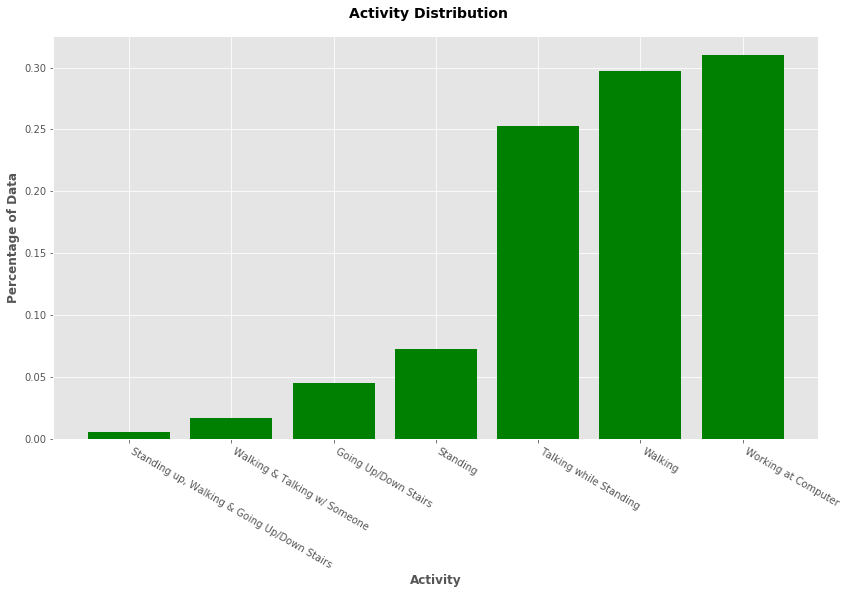

In [23]:
proportion = averager.aggregated_df.groupby('label').count()['seq'] / averager.aggregated_df.shape[0]
proportion.sort_values(inplace=True)

bar_plot(proportion.index, proportion, 'green', 'Activity', 'Percentage of Data','Activity Distribution', True)

### Next Steps

There are a few ways in which this analysis/model could be improved:

##### Model Improvements
* Increase the lag, allowing the model to look further back in time.
    * Since introducing the lagged variables, as well as the rolling average significantly increased the accuracy, it would be worth experimenting with how far back we allow the data to look
    * One of the downsides of increasing the lag is, if this model were to go into production, data would have to be cached for the same amount of the lag before the model could make a prediction.
* Test various model architectures, including those that are specifically designed for sequential data, such as an RNN or LSTM. Pit all of these models againsts each other and see which comes out on top.

##### Data Improvements
* Although the model performed relatively well on classifying each class, the uneven distribution of classes in the data set could be remedied by a sampling technique such as T-Distributed Stochastic Neighbor Embedding (t-SNE) or simply running the experiment for a longer period of time (accelerometers are not overly expensive and finding subjects to wear one for a day shouldn't be too difficult).

* In the ActivitySequenceAverager class, I am using an *inner* join to join the different participants dataframes. The reason I did this is to not only join on the activity type, but also on the sequence number as well. This gives me a full view of the average persons "experience" throughout a given activity.
    
    However, there is data loss with inner joins. If subject 1 has 1,000 *Working at Computer* measurements and subject 2 has 2,000, an inner join will only include the first 1,000 of subject 2 (after my resequencing method). In the future. these observations could be used as the testing data, allowing me to forgo a train test split in this analysis, freeing up more data for the model to train with (which often leads to a superior model.
    
##### Data Aggregation Paths

1. The current data aggregation technique that I am using is one where I average all 15 participants accelerometer measurements to create one view of the "average" experience through a given activity.

    From a reductionist perspective, there is nothing inherently wrong with this; the model is training on the training set and testing on unseen observations in the testing set. However, holisticly, each subjects *behavior* (the manner in which they move during these activities) is used to train the model, and then the model is used to predict instances of that same behavior pattern. It would be worthwile to leave one subject out of the averaging process and use their data as the testing set, to see how the model performs on behavior it hasn't been exposed too.
    
2. An alternate route would be to not do any averaging at all and "stack" the dataframes of each subject on top of one another, leading to a drastically larger sample set. In order to do this, any lag attributes would have to be computed before the stacking was performed, so that, for example, the end of subject 1's data isn't incorporated into subject 2's rolling average.